In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import cv2
import numpy as np
import matplotlib.pyplot as plt

import os
from tqdm import tqdm

import neptune.new as neptune

In [2]:
def show_image(data_dir='/Users/nielspace/Documents/data/birds/train/'):
    list_dir = os.listdir(data_dir)
    rand_d = np.random.randint(0, len(list_dir))
    rand_d = list_dir[rand_d]
    img_dir = data_dir+rand_d
    image = os.listdir(img_dir)
    rand_i = np.random.randint(len(image))
    img_src = img_dir+'/'+image[rand_i]
    img = cv2.imread(img_src)
    resize = cv2.resize(img, (100,100))
    plt.figure(figsize=(10,8))
    plt.imshow(img)
    plt.title(rand_d)
    
    
    plt.axis('off')
    plt.show()

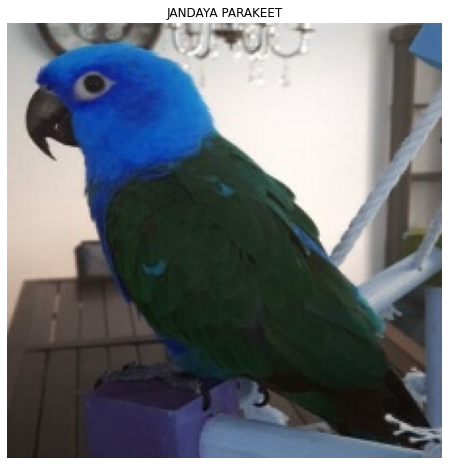

In [3]:
show_image()

# Create Dataset

In [4]:
train_dir = '/Users/nielspace/Documents/data/birds/train/'
val_dir = '/Users/nielspace/Documents/data/birds/valid/'
test_dir = '/Users/nielspace/Documents/data/birds/test/'

bs = 1
crop_size = 128

def dataset(bs, crop_size, sample_size='full'):
    transformations = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize(crop_size),
        torchvision.transforms.CenterCrop(crop_size),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    if sample_size == 'full':
        train_data = torchvision.datasets.ImageFolder(root=train_dir, transform=transformations)
        test_data = torchvision.datasets.ImageFolder(root=test_dir, transform=transformations)
        valid_data = torchvision.datasets.ImageFolder(root=val_dir, transform=transformations)
        
        train_data = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=bs)
        test_data = torch.utils.data.DataLoader(valid_data, shuffle=True, batch_size=bs)
        test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=bs)
    
    else:
        train_data = torchvision.datasets.ImageFolder(root=train_dir, transform=transformations)
        test_data = torchvision.datasets.ImageFolder(root=test_dir, transform=transformations)
        valid_data = torchvision.datasets.ImageFolder(root=val_dir, transform=transformations)
        
        indices = torch.arange(sample_size)
        p20_v = (20/100)*len(valid_data)
        p20_v = torch.arange(p20_v)
        p20_t = (20/100)*len(test_data)
        p20_t = torch.arange(p20_t)
        
        assert len(indices) > len(p20_v), "Training samples should be more than validation and test samples"
        train_data = torch.utils.data.Subset(train_data, indices)
        test_data = torch.utils.data.Subset(test_data, p20_t)
        valid_data = torch.utils.data.Subset(valid_data, p20_v)
        
        train_data = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=bs)
        valid_data = torch.utils.data.DataLoader(valid_data, shuffle=True, batch_size=bs)
        test_data = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=bs)
    
    return train_data, valid_data, test_data

In [5]:
train_data, val_data, test_data = dataset(bs,100, 1000)

In [6]:
train_data.batch_size

1

In [7]:
len(train_data), len(val_data)

(1000, 400)

# Data Modeling

In [8]:
from attention import Attention
from transformer import Transformer, ViT

import torch
import torch.nn.functional as F

from torch import nn
from einops import rearrange
import time

In [13]:
class Config:
    hidden_dims = 768
    in_channels = 3
    img_size = (128,128)

config = Config()
config.__dict__

{}

In [18]:
print(config.__dict__)

{}


In [10]:
from torch.nn.modules.utils import _pair
from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm

class Embeddings(nn.Module):
    """Construct the embeddings from patch, position embeddings.
    """
    def __init__(self, img_size=128, hidden_dims=768, 
                 in_channels=3
                ):
        
        super(Embeddings, self).__init__()
        img_size = _pair(img_size)
        
        patch_size = _pair(img_size)
        n_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])
        
        self.patch_embeddings = Conv2d(in_channels=in_channels,
                                       out_channels=hidden_dims,
                                       kernel_size=patch_size,
                                       stride=patch_size)
        
        self.position_embeddings = nn.Parameter(torch.zeros(1, n_patches+1, hidden_dims))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, hidden_dims))

        self.dropout = Dropout(0.1)

    def forward(self, x):
        B = x.shape[0]
        cls_tokens = self.cls_token.expand(B, -1, -1)

        x = self.patch_embeddings(x)
        x = x.flatten(2)
        x = x.transpose(-1, -2)
        x = torch.cat((cls_tokens, x), dim=1)

        embeddings = x+self.position_embeddings
        embeddings = self.dropout(embeddings)
        return embeddings


In [20]:
x = torch.randn(1,3*config.img_size[0]*config.img_size[1])
x = x.reshape(1,config.in_channels,config.img_size[0],config.img_size[1])
e = Embeddings()
e(x)

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.7426, -0.3532, -0.0000,  ..., -0.0452, -0.8451, -0.2322]]],
       grad_fn=<MulBackward0>)

In [21]:
import math

class Attention(nn.Module):
    def __init__(self, num_attention_heads=12, hidden_size=768, attention_dropout_rate=0.1):
        super(Attention, self).__init__()
        self.num_attention_heads = num_attention_heads
        self.attention_head_size = int(hidden_size / self.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = Linear(hidden_size, self.all_head_size)
        self.key = Linear(hidden_size, self.all_head_size)
        self.value = Linear(hidden_size, self.all_head_size)

        self.out = Linear(hidden_size, self.all_head_size)
        self.attn_dropout = Dropout(attention_dropout_rate)
        self.proj_dropout = Dropout(attention_dropout_rate)

        self.softmax = torch.nn.Softmax(dim=-1)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = self.softmax(attention_scores)
        weights = attention_probs 
        attention_probs = self.attn_dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        attention_output = self.out(context_layer)
        attention_output = self.proj_dropout(attention_output)
        return attention_output, weights
    
A = Attention()
A(e(x))[0].shape, A(e(x))[1].shape

(torch.Size([1, 2, 768]), torch.Size([1, 12, 2, 2]))

In [224]:
class Mlp(nn.Module):
    def __init__(self, hidden_size=768, linear_dim=3072, dropout_rate=0.1, std_norm=1e-6):
        super(Mlp, self).__init__()
        self.fc1 = Linear(hidden_size, linear_dim)
        self.fc2 = Linear(linear_dim, hidden_size)
        self.act_fn = torch.nn.functional.gelu
        self.dropout = Dropout(dropout_rate)
        self.std_norm = std_norm
        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.normal_(self.fc1.bias, std=self.std_norm)
        nn.init.normal_(self.fc2.bias, std=self.std_norm)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act_fn(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x
    
Mlp()

Mlp(
  (fc1): Linear(in_features=768, out_features=3072, bias=True)
  (fc2): Linear(in_features=3072, out_features=768, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [226]:
# norm(emb(x))
class Block(nn.Module):
    def __init__(self, num_attention_heads=12, hidden_size=768, linear_dim=3072, dropout_rate=0.1,
                 attention_dropout_rate=0.1, eps=1e-6, std_norm=1e-6):
        
        super(Block, self).__init__()
        self.hidden_size = hidden_size
        self.attention_norm = LayerNorm(hidden_size, eps=eps)
        self.ffn_norm = LayerNorm(hidden_size, eps=eps)
        self.ffn = Mlp(hidden_size=hidden_size, linear_dim=linear_dim,
                       dropout_rate=dropout_rate)
        self.attn = Attention(num_attention_heads=num_attention_heads, hidden_size=hidden_size, 
                              attention_dropout_rate=attention_dropout_rate)

    def forward(self, x):
        h = x
        x = self.attention_norm(x)
        x, weights = self.attn(x)
        x = x + h
        h = x
        x = self.ffn_norm(x)
        x = self.ffn(x)
        x = x + h
        return x, weights

b=Block()
b(e(x))

(tensor([[[-1.4086,  0.4009, -0.6227,  ..., -0.9070, -0.1340, -1.6239],
          [-1.1504, -0.0454,  0.9900,  ..., -0.2662, -0.7596,  0.2832]]],
        grad_fn=<AddBackward0>),
 tensor([[[[0.5002, 0.4998],
           [0.5914, 0.4086]],
 
          [[0.4961, 0.5039],
           [0.5220, 0.4780]],
 
          [[0.5052, 0.4948],
           [0.4498, 0.5502]],
 
          [[0.4995, 0.5005],
           [0.6421, 0.3579]],
 
          [[0.4975, 0.5025],
           [0.4758, 0.5242]],
 
          [[0.4973, 0.5027],
           [0.5082, 0.4918]],
 
          [[0.4982, 0.5018],
           [0.4730, 0.5270]],
 
          [[0.5008, 0.4992],
           [0.4707, 0.5293]],
 
          [[0.5006, 0.4994],
           [0.5241, 0.4759]],
 
          [[0.4999, 0.5001],
           [0.5717, 0.4283]],
 
          [[0.4973, 0.5027],
           [0.4286, 0.5714]],
 
          [[0.4969, 0.5031],
           [0.3390, 0.6610]]]], grad_fn=<SoftmaxBackward0>))

In [182]:
import copy
class Encoder(nn.Module):
    def __init__(self, num_layers=12):
        super(Encoder, self).__init__()
        self.layer = nn.ModuleList()
        self.encoder_norm = LayerNorm(768, eps=1e-6)
        for _ in range(num_layers):
            layer = Block()
            self.layer.append(copy.deepcopy(layer))

    def forward(self, hidden_states):
        attn_weights = []
        for layer_block in self.layer:
            hidden_states, weights = layer_block(hidden_states)
            attn_weights.append(weights)
        encoded = self.encoder_norm(hidden_states)
        return encoded, attn_weights
    
enc = Encoder()

enc(e(x))

(tensor([[[ 1.9272,  0.9585, -0.9891,  ..., -0.5438, -1.2153,  0.2939],
          [ 1.2279,  1.1079,  1.2356,  ...,  0.2765, -2.0210, -0.4086]]],
        grad_fn=<NativeLayerNormBackward0>),
 [tensor([[[[0.5006, 0.4994],
            [0.6385, 0.3615]],
  
           [[0.5043, 0.4957],
            [0.5917, 0.4083]],
  
           [[0.4920, 0.5080],
            [0.5143, 0.4857]],
  
           [[0.4999, 0.5001],
            [0.4206, 0.5794]],
  
           [[0.5029, 0.4971],
            [0.6068, 0.3932]],
  
           [[0.5000, 0.5000],
            [0.4809, 0.5191]],
  
           [[0.5043, 0.4957],
            [0.4578, 0.5422]],
  
           [[0.5013, 0.4987],
            [0.3194, 0.6806]],
  
           [[0.4977, 0.5023],
            [0.4897, 0.5103]],
  
           [[0.4955, 0.5045],
            [0.3751, 0.6249]],
  
           [[0.5008, 0.4992],
            [0.4372, 0.5628]],
  
           [[0.4992, 0.5008],
            [0.4462, 0.5538]]]], grad_fn=<SoftmaxBackward0>),
  tensor([[[[

In [185]:
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.embeddings = Embeddings(16)
        self.encoder = Encoder()

    def forward(self, input_ids):
        embedding_output = self.embeddings(input_ids)
        encoded, attn_weights = self.encoder(embedding_output)
        return encoded, attn_weights

In [186]:
T = Transformer()
T(x)

(tensor([[[ 0.2177, -1.4037, -0.7043,  ...,  0.9107,  0.0742, -0.1003],
          [ 0.8666, -0.3561, -0.3517,  ...,  0.6197,  1.1589,  0.2991]]],
        grad_fn=<NativeLayerNormBackward0>),
 [tensor([[[[0.4994, 0.5006],
            [0.4263, 0.5737]],
  
           [[0.4981, 0.5019],
            [0.4547, 0.5453]],
  
           [[0.5011, 0.4989],
            [0.4939, 0.5061]],
  
           [[0.5020, 0.4980],
            [0.4966, 0.5034]],
  
           [[0.4950, 0.5050],
            [0.5357, 0.4643]],
  
           [[0.5063, 0.4937],
            [0.5968, 0.4032]],
  
           [[0.5006, 0.4994],
            [0.4887, 0.5113]],
  
           [[0.5013, 0.4987],
            [0.4903, 0.5097]],
  
           [[0.5020, 0.4980],
            [0.6589, 0.3411]],
  
           [[0.5009, 0.4991],
            [0.6224, 0.3776]],
  
           [[0.5011, 0.4989],
            [0.6164, 0.3836]],
  
           [[0.4998, 0.5002],
            [0.5528, 0.4472]]]], grad_fn=<SoftmaxBackward0>),
  tensor([[[[

In [192]:
class VisionTransformer(nn.Module):
    def __init__(self):
        super(VisionTransformer, self).__init__()
#         self.num_classes = num_classes
        self.classifier = 'token'

        self.transformer = Transformer()
        self.head = Linear(768, 400)

    def forward(self, x, labels=None):
        x, attn_weights = self.transformer(x)
        logits = self.head(x[:, 0])

        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, 400), labels.view(-1))
            return loss
        else:
            return logits, attn_weights

In [201]:
model = VisionTransformer()
logits, attn_weights = model(x)

In [202]:
logits.shape, len(attn_weights[0])

(torch.Size([1, 400]), 1)

In [203]:
optimizer = optim.Adam(model.parameters(), lr=0.003)
# run = neptune.init(
#     project="nielspace/ViT-bird-classification",
#     api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkYjRhYzI0Ny0zZjBmLTQ3YjYtOTY0Yi05ZTQ4ODM3YzE0YWEifQ==",
# )

In [204]:
def train_Engine(n_epochs,
                 train_data,
                 val_data,
                 model,
                 optimizer,
                 loss_fn,
                 device,
                 train_loss_history,
                 val_loss_history,
                 monitoring=False):

    yhat = []
    y_o = []
    for epoch in range(1, n_epochs + 1):
        print('Epoch:', epoch)
        for i, (data, target) in tqdm(enumerate(train_data), total=len(train_data), desc="Training"):
            total_samples = len(train_data.dataset)
            
            #device
            model = model.to(device)
            x = data.to(device)
            y = target.to(device)
            
            optimizer.zero_grad()
            output = F.log_softmax(model.forward(x), dim=1)

            y_o.append(y)
            yhat.append(output)
            
            accuracy = torch.sum(output == y).item()/len(train_data)
            loss = F.nll_loss(output, y)
            loss.backward()
            optimizer.step()
            
            if monitoring:
                run['Training_loss'].log(loss.item())
                run['Training_acc'].log(accuracy.item())

            
        model.eval()
        total_samples = len(valid_data.dataset)
        correct_samples = 0
        total_loss = 0

        with torch.no_grad():
            for i, (data, target) in tqdm(enumerate(valid_data), total=len(train_data), desc="Valuation"):
                
                model = model.to(device)
                x = data.to(device)
                y = target.to(device)

                output = F.log_softmax(model(x), dim=1)
                val_loss = F.nll_loss(output, y, reduction='sum')
                _, pred = torch.max(output, dim=1)
                
                total_loss += val_loss.item()
                correct_samples += pred.eq(y).sum()
                val_acc = torch.sum(pred == y).item()/len(val_data)
                avg_loss = total_loss / total_samples
                val_loss_history.append(avg_loss)

                if monitoring:
                    run['Val_loss'].log(avg_loss)
                    run['Val_accuracy'].log(val_acc)


In [210]:
train_Engine(n_epochs=2,
             train_data=train_data,
             val_data=val_data,
             model=model,
             optimizer=optimizer,
             loss_fn='nll_loss',
             device='mps',
             train_loss_history=[],
             val_loss_history=[],)


Epoch: 1


Training:   0%|                                                                                | 0/1000 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (37) must match the size of tensor b (2) at non-singleton dimension 1

In [1]:
run.stop()

NameError: name 'run' is not defined

In [32]:
run["parameters"] = params

for epoch in range(10):
    run["train/loss"].log(0.9 ** epoch)

run["eval/f1_score"] = 0.66

run.stop()

https://app.neptune.ai/nielspace/ViT-bird-classification/e/VIT-1


Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs.neptune.ai/you-should-know/what-can-you-log-and-display#hardware-consumption


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 22 operations to synchronize with Neptune. Do not kill this process.
All 22 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/nielspace/ViT-bird-classification/e/VIT-1


In [10]:
from config import Config

In [19]:
PARAMS = {}
for key, val in Config.__dict__.items():
    if key not in ['__module__', '__dict__', '__weakref__', '__doc__']:
        PARAMS[key] = val
        
PARAMS

{'IMG_SIZE': 224,
 'CROP_SIZE': 224,
 'BATCH_SIZE': 128,
 'N_SAMPLES': 400,
 'N_TRAIN': 400,
 'N_VAL': 400,
 'N_TEST': 400,
 'LR': 0.003,
 'OPIMIZER': 'Adam',
 'N_CLASSES': 400,
 'N_CHANNELS': 3,
 'LATENT_DIM': 100,
 'N_ITER': 400,
 'OUTPUT': 'softmax',
 'LOSS_FN': 'nll_loss',
 'DEVICE': ['cpu', 'mps', 'cuda'],
 'N_EPOCHS': 100,
 'TRAIN_LOSS_HISTORY': [],
 'VAL_LOSS_HISTORY': []}

In [30]:
Config.__dict__

mappingproxy({'__module__': 'config',
              'IMG_SIZE': 224,
              'CROP_SIZE': 224,
              'BATCH_SIZE': 128,
              'N_SAMPLES': 400,
              'N_TRAIN': 400,
              'N_VAL': 400,
              'N_TEST': 400,
              'LR': 0.003,
              'OPIMIZER': 'Adam',
              'N_CLASSES': 400,
              'N_CHANNELS': 3,
              'LATENT_DIM': 100,
              'N_ITER': 400,
              'OUTPUT': 'softmax',
              'LOSS_FN': 'nll_loss',
              'DEVICE': ['cpu', 'mps', 'cuda'],
              'N_EPOCHS': 100,
              'TRAIN_LOSS_HISTORY': [],
              'VAL_LOSS_HISTORY': [],
              '__dict__': <attribute '__dict__' of 'Config' objects>,
              '__weakref__': <attribute '__weakref__' of 'Config' objects>,
              '__doc__': None})

In [22]:
train_data.dataset.dataset.classes

['ABBOTTS BABBLER',
 'ABBOTTS BOOBY',
 'ABYSSINIAN GROUND HORNBILL',
 'AFRICAN CROWNED CRANE',
 'AFRICAN EMERALD CUCKOO',
 'AFRICAN FIREFINCH',
 'AFRICAN OYSTER CATCHER',
 'ALBATROSS',
 'ALBERTS TOWHEE',
 'ALEXANDRINE PARAKEET',
 'ALPINE CHOUGH',
 'ALTAMIRA YELLOWTHROAT',
 'AMERICAN AVOCET',
 'AMERICAN BITTERN',
 'AMERICAN COOT',
 'AMERICAN GOLDFINCH',
 'AMERICAN KESTREL',
 'AMERICAN PIPIT',
 'AMERICAN REDSTART',
 'AMETHYST WOODSTAR',
 'ANDEAN GOOSE',
 'ANDEAN LAPWING',
 'ANDEAN SISKIN',
 'ANHINGA',
 'ANIANIAU',
 'ANNAS HUMMINGBIRD',
 'ANTBIRD',
 'ANTILLEAN EUPHONIA',
 'APAPANE',
 'APOSTLEBIRD',
 'ARARIPE MANAKIN',
 'ASHY THRUSHBIRD',
 'ASIAN CRESTED IBIS',
 'AVADAVAT',
 'AZURE JAY',
 'AZURE TANAGER',
 'AZURE TIT',
 'BAIKAL TEAL',
 'BALD EAGLE',
 'BALD IBIS',
 'BALI STARLING',
 'BALTIMORE ORIOLE',
 'BANANAQUIT',
 'BAND TAILED GUAN',
 'BANDED BROADBILL',
 'BANDED PITA',
 'BANDED STILT',
 'BAR-TAILED GODWIT',
 'BARN OWL',
 'BARN SWALLOW',
 'BARRED PUFFBIRD',
 'BARROWS GOLDENEYE',
 'BAY-B

In [48]:
with open('../metadata/classes.txt', 'r') as f:
    classes = f.read().split('\n')

In [51]:
classes[100]

'CASSOWARY'

In [78]:
from PIL import Image
import requests
from urllib.request import urlretrieve
import streamlit as st

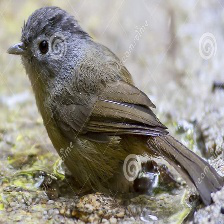

In [55]:
Image.open('../../../data/birds/train/ABBOTTS BABBLER/001.jpg')

In [74]:
path = 'https://commons.wikimedia.org/wiki/File:Abbott%27s_babbler_%28Malacocincla_abbotti%29.jpg'
r = requests.get(path).content
r

b'<!DOCTYPE html>\n<html class="client-nojs" lang="en" dir="ltr">\n<head>\n<meta charset="UTF-8"/>\n<title>File:Abbott\'s babbler (Malacocincla abbotti).jpg - Wikimedia Commons</title>\n<script>document.documentElement.className="client-js";RLCONF={"wgBreakFrames":true,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"5b23d0e4-e631-45fd-b425-fd33c591bd0b","wgCSPNonce":false,"wgCanonicalNamespace":"File","wgCanonicalSpecialPageName":false,"wgNamespaceNumber":6,"wgPageName":"File:Abbott\'s_babbler_(Malacocincla_abbotti).jpg","wgTitle":"Abbott\'s babbler (Malacocincla abbotti).jpg","wgCurRevisionId":492066181,"wgRevisionId":492066181,"wgArticleId":36449432,"wgIsArticle":true,"wgIsRedirect":false,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Flickr images reviewed by Flickre

In [75]:
urlretrieve(path, 'i.jpg')

('i.jpg', <http.client.HTTPMessage at 0x17eb85af0>)

In [77]:
Image.open('i.jpg')

UnidentifiedImageError: cannot identify image file 'i.jpg'

In [79]:
st.image(path)

2022-07-06 22:51:44.394 
  command:

    streamlit run /opt/homebrew/Caskroom/miniforge/base/envs/pytorchenv/lib/python3.8/site-packages/ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [80]:
!streamlit run /opt/homebrew/Caskroom/miniforge/base/envs/pytorchenv/lib/python3.8/site-packages/ipykernel_launcher.py


  👋 Welcome to Streamlit!

  If you're one of our development partners or you're interested in getting
  personal technical support or Streamlit updates, please enter your email
  address below. Otherwise, you may leave the field blank.

  Email:  ^C
2022-07-06 22:52:41.851 
